# Dermatologist AI Mini-project

This work is a modification of a project by William Zhu (Wai Yan, @blackblitz on gihtub.  https://github.com/blackblitz/dermatologist-ai).  

A few tweaks (the model's dropout rate, and the optimization method) managed to improve results enough to merit sharing the work here.

In this mini-project, images of skin lesions are classified into melanoma, nevus and seborrheic keratosis. The approach used is a pretrained model [ResNet50](https://arxiv.org/abs/1512.03385) from the ImageNet work [ImageNet](http://www.image-net.org/).  The kares application for [ResNet50](https://keras.io/applications/#resnet50) is used.  Other keras applications such as InceptionV3 and VGG19 were also used but none yielded results equal to those of ResNet50 on this dataset.

William's approach proved to be insightful and relatively clean.  Further work to improve the results could include increasing the number and variety of data set images, continued tweaking of the bottleneck layers, and further exploration of other keras applications.  

## Loading the dataset

First load the training, validation and testing sets and resize the images to 224×224, which is required for ResNet50. Then, we preprocess the images for ResNet50.

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

Using TensorFlow backend.


In [2]:
train_files, train_targets = load_dataset('../data/train')
valid_files, valid_targets = load_dataset('../data/valid')
test_files, test_targets = load_dataset('../data/test')

In [3]:
from os import listdir

diseases = sorted(listdir('../data/train'))

print('There are {} classes: {}.'.format(len(diseases), ', '.join(diseases)))
print('There are {} training images.'.format(len(train_files)))
print('There are {} validation images.'.format(len(valid_files)))
print('There are {} testing images.'.format(len(test_files)))

There are 3 classes: melanoma, nevus, seborrheic_keratosis.
There are 2000 training images.
There are 150 validation images.
There are 600 testing images.


In [4]:
from keras.preprocessing import image
from tqdm import tqdm_notebook

def get_tensor(path):
    img = image.load_img(path, target_size=(224, 224))
    return np.expand_dims(image.img_to_array(img), axis=0)

def get_tensors(paths):
    return np.vstack([get_tensor(path) for path in tqdm_notebook(paths)])

In [5]:
from keras.applications.resnet50 import preprocess_input

train_tensors = preprocess_input(get_tensors(train_files))
valid_tensors = preprocess_input(get_tensors(valid_files))
test_tensors = preprocess_input(get_tensors(test_files))

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


## Building the model
Because we are using and adding to pretrained models, we are effectively using transfer learning. All the images are presented to the ResNet50 application with the top layers chopped off and weights pretrained from ImageNet. Then, we train these bottleneck features in a neural network with a Global Average Pooling layer and 3 fully connected layers. The architecture is depicted below.

![alt Transfer learning architecture](images/derm_ai_arch.png)

In [6]:
from keras.applications.resnet50 import ResNet50

resnet50 = ResNet50(include_top=False, input_shape=(224, 224, 3))


In [7]:
print(train_tensors.shape)
train_bottleneck = resnet50.predict(train_tensors)
valid_bottleneck = resnet50.predict(valid_tensors)
test_bottleneck =  resnet50.predict(test_tensors)

(2000, 224, 224, 3)


In [8]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_bottleneck.shape[1:]))
model.add(Dropout(0.65))
model.add(Dense(2048, activation='tanh')) 
model.add(Dropout(0.65))
model.add(Dense(2048, activation='tanh'))


model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6147      
Total params: 8,398,851.0
Trainable params: 8,398,851.0
Non-trainable params: 0.0
____________________________________________________________

## Training the model
We train the model by using stochastic gradient descent with momentum for 100 epochs. Hyperparameter tuning is done by trying different configurations on the number of nodes in the first and second dense layers and the learning rate and looking at the loss curve.

In [9]:
from keras import optimizers

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [10]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='resnet.from.bottleneck.hdf5', save_best_only=True)
history = model.fit(train_bottleneck, train_targets, epochs=100,
          validation_data=(valid_bottleneck, valid_targets),
          callbacks=[checkpointer], verbose=1, shuffle=True)

Train on 2000 samples, validate on 150 samples
Epoch 1/100
2000/2000 [==============================] - 8s - loss: 1.7967 - acc: 0.6035 - val_loss: 1.0527 - val_acc: 0.5200

In [11]:
model.load_weights('resnet.from.bottleneck.hdf5')

In [12]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*model.evaluate(test_bottleneck, test_targets)))

512/600 [========================>.....] - ETA: 0s
Testing loss: 0.6582
Testing accuracy: 0.7633


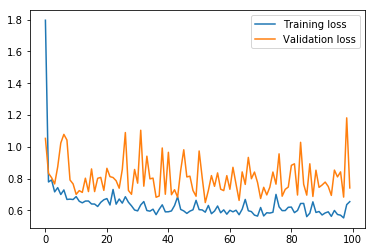

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

## Evaluating the model

A decent testing accuracy is achieved. Now e examine the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve and [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

AUC for melanoma: 0.7860
AUC for nevus: 0.8547
AUC for seborrheic_keratosis: 0.9023


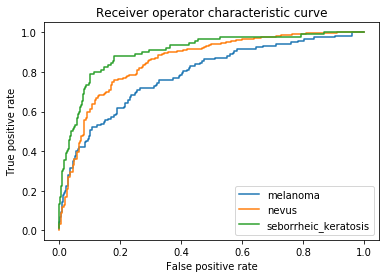

In [14]:
from sklearn.metrics import roc_curve, auc

for i in range(len(diseases)):
    fpr, tpr, _ = roc_curve(test_targets[:,i], model.predict(test_bottleneck)[:,i])
    print('AUC for {}: {:.4f}'.format(diseases[i], auc(fpr, tpr)))
    plt.plot(fpr, tpr, label=diseases[i])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('Receiver operator characteristic curve')
plt.show()

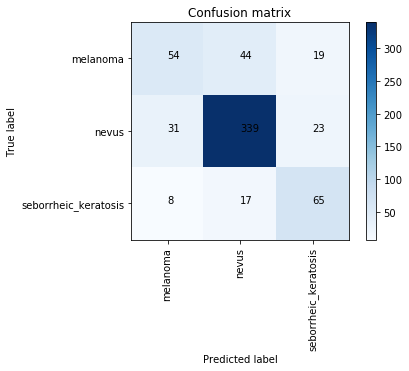

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(model.predict(test_bottleneck), axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(diseases))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, diseases, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, diseases)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

## Storing predictions in a csv file

As part of this mini-project, we store the predictions in a csv file in order to receive evaluation and scoring.

In [16]:
import csv

with open('predictions.csv', 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(['Id', 'task_1', 'task_2'])
    for path in tqdm_notebook(sorted(test_files)):
        tensor = preprocess_input(get_tensor(path))
        pred = model.predict(resnet50.predict(tensor))[0]
        csvwriter.writerow([path, pred[0], pred[2]])

Widget Javascript not detected.  It may not be installed or enabled properly.
